In [5]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, r2_score
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

In [4]:
def train_linear_regression_model(df, features, target, test_size=0.3, random_state=23):
    """
    Trains a linear regression model on the given data.

    Args:
        df (pandas.DataFrame): The input DataFrame containing features and target variable.
        features (list): A list of column names representing the features.
        target (str): The name of the column representing the target variable.
        test_size (float): The proportion of the dataset to include in the test split.
        random_state (int): Controls the shuffling applied to the data before applying the split.

    Returns:
        tuple: A tuple containing the trained linear regression model, predicted target values for the test set, 
               and predicted target values for the training set.
    """
    X = df.loc[:, features]
    Y = df[target]

    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=test_size, random_state=random_state, shuffle=True)

    model = LinearRegression()
    model.fit(X_train, Y_train)

    Y_pred = model.predict(X_test)
    Y_pred_train = model.predict(X_train)

    return model, Y_pred, Y_pred_train, X_train, X_test, Y_train, Y_test

df = pd.read_csv('../Datasets/annotated_dataset.csv', nrows=1000)
df['generated'] = df["generated"].astype('int')

features = ["text_length", "unique_word_count", "stop_word_count", "special_character_count"]
target = "average_word_length"

model, Y_pred, Y_pred_train, X_train, X_test, Y_train, Y_test = train_linear_regression_model(df, features, target)

print("Model's score", model.score(X_test, Y_test))

0.7744100366691318


In [7]:
def print_stats(x_vals, y_vals):
    mse = mean_squared_error(x_vals, y_vals)
    rmse = np.sqrt(mse)
    mape = mean_absolute_percentage_error(x_vals, y_vals)
    r2 = r2_score(x_vals, y_vals)

    print("MSE: ", mse)
    print("RMSE: ", rmse)
    print("MAPE: ", mape)
    print("R2: ", r2)



print("Training Metrics")
print_stats(Y_train, Y_pred_train)
print()
print("Testing Metrics")
print_stats(Y_test, Y_pred)

Training Metrics
MSE:  1.3862989493582245e-05
RMSE:  0.0037233035725793627
MAPE:  0.015875983946905856
R2:  0.7312450749334658

Testing Metrics
MSE:  1.2688941321692714e-05
RMSE:  0.003562154028350362
MAPE:  0.0156624101458323
R2:  0.7744100366691318


In [8]:
kmeans = KMeans(n_clusters=2, random_state=0, n_init='auto')
kmeans.fit(X_train)

display(kmeans.cluster_centers_)

array([[2729.18556701,  244.56701031,  230.51134021,  541.32164948],
       [4344.90232558,  355.89767442,  358.96744186,  856.09302326]])

In [9]:
kmeans = KMeans(n_clusters=2, random_state=42).fit(X_train) 
shil_score = silhouette_score(X_train, kmeans.labels_) 
cal_har_score = calinski_harabasz_score(X_train, kmeans.labels_) 
davi_score = davies_bouldin_score(X_train, kmeans.labels_)

print("Silhouette Score: ", shil_score)
print("Calinski Harabasz Score: ", cal_har_score)
print("Davies Bouldin Score: ", davi_score)

Silhouette Score:  0.5934930010860674
Calinski Harabasz Score:  1141.3543794468337
Davies Bouldin Score:  0.5881780244808492


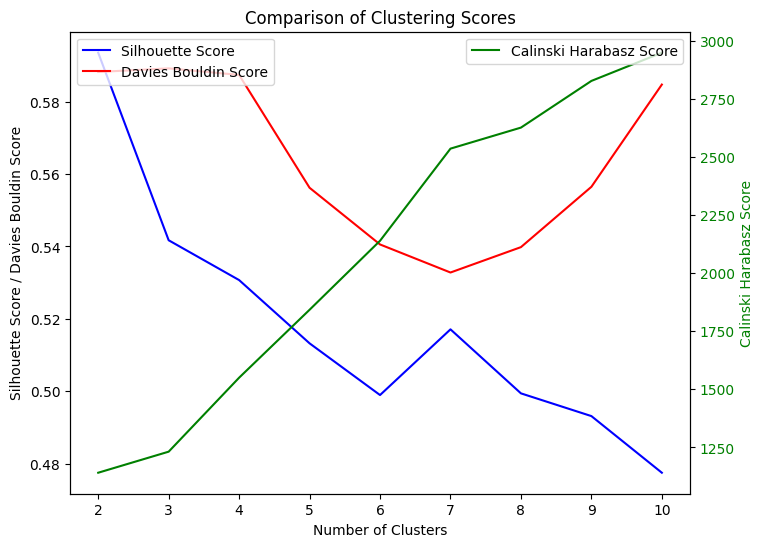

In [10]:
def evaluate_kmeans_clustering(X, max_clusters=10):
    """
    Evaluates K-Means clustering for different numbers of clusters using Silhouette Score, 
    Calinski-Harabasz Index, and Davies-Bouldin Index.

    Args:
        X (numpy.ndarray or pandas.DataFrame): The data to cluster.
        max_clusters (int): The maximum number of clusters to evaluate.

    Returns:
        tuple: A tuple containing lists of Silhouette Scores, Calinski-Harabasz Indices, and Davies-Bouldin Indices 
               for different numbers of clusters.
    """
    sil_scores = []
    cal_har_scores = []
    davi_scores = []

    for i in range(2, max_clusters + 1):
        kmeans = KMeans(n_clusters=i, random_state=42).fit(X)
        sil_score = silhouette_score(X, kmeans.labels_)
        cal_har_score = calinski_harabasz_score(X, kmeans.labels_)
        davi_score = davies_bouldin_score(X, kmeans.labels_)

        sil_scores.append(sil_score)
        cal_har_scores.append(cal_har_score)
        davi_scores.append(davi_score)

    return sil_scores, cal_har_scores, davi_scores


sil_scores, cal_har_scores, davi_scores = evaluate_kmeans_clustering(X_train)

fig, ax1 = plt.subplots(figsize=(8, 6))

# Plotting Silhouette Score and Davies Bouldin Score on the first y-axis
ax1.plot(range(2, 11), sil_scores, label='Silhouette Score', color='blue')
ax1.plot(range(2, 11), davi_scores, label='Davies Bouldin Score', color='red')
ax1.set_xlabel('Number of Clusters')
ax1.set_ylabel('Silhouette Score / Davies Bouldin Score', color='black')
ax1.tick_params(axis='y', labelcolor='black')

# Create a second y-axis for Calinski Harabasz Score
ax2 = ax1.twinx()
ax2.plot(range(2, 11), cal_har_scores, label='Calinski Harabasz Score', color='green')
ax2.set_ylabel('Calinski Harabasz Score', color='green')
ax2.tick_params(axis='y', labelcolor='green')

# Add legends
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

plt.title('Comparison of Clustering Scores')
plt.show()

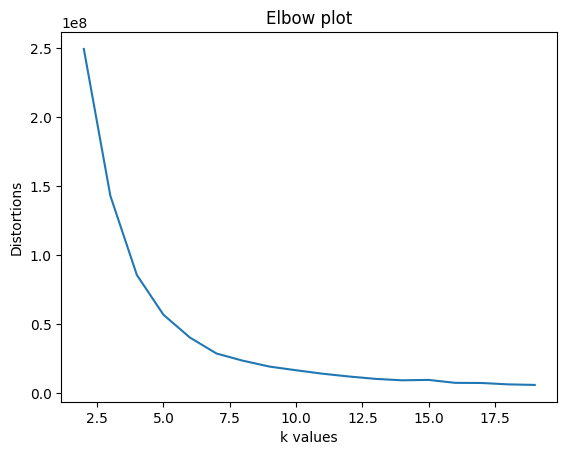

In [11]:
def plot_elbow_method(X, Y, max_clusters=20):
    """
    Plots the elbow method graph to determine the optimal number of clusters for K-Means clustering.

    Args:
        X (numpy.ndarray or pandas.DataFrame): The data to cluster.
        max_clusters (int): The maximum number of clusters to consider.
    """
    distortions = []
    k_values = range(2, max_clusters)

    for k in k_values:
        kmeans = KMeans(n_clusters=k, n_init="auto")
        kmeans.fit(X, Y)
        distortions.append(kmeans.inertia_)

    return k_values, distortions


k_values, distortions = plot_elbow_method(X_train, Y_train)

plt.plot(k_values, distortions)
plt.title("Elbow plot")
plt.xlabel("k values")
plt.ylabel("Distortions")
plt.show()